# Assignment 8: Software

Intel optimized libraries allow use of the same python code for AI and Data Science as standard python libraries. One major difference is that the optimized libraries experience a speedup. This assignment asks you to use Intel optimized python libraries.

# Install intel optimized python libraries

First, if you haven’t already, install the Conda package management system. Instructions [here](https://conda.io/docs/user-guide/install/index.html).

Test that conda is working by running `conda list` in your terminal or command prompt.

Install Intel optimized libraries.

```bash
conda update conda
conda config --add channels intel
conda create -n idp intelpython3_core python=3
```

Add this new env to your jupyter kernels:

```bash
conda install jupyter
python -m ipykernel install --user --name idp --display-name "Python (idp)"
```

Install the packages we need for the assignment:

```bash
source activate idp
conda install tensorflow-gpu keras scikit-learn pandas seaborn
```

As of February 2018, there’s a package conflict. You may receive something like

```
> Solving environment: failed
> 
> UnsatisfiableError: The following specifications were found to be in conflict:
>   - keras
>   - mkl_random
> Use "conda info <package>" to see the dependencies for each package.
```

In that case, remove the conflicting `mkl_*` packages first, then re-execute the above command to install keras and the other libraries. Conda will automatically replace the incompatible `mkl_*` libraries with with compatible ones. 

```bash
conda uninstall mkl_fft mkl_random
```

Finally, start jupyter notebook as you usually would. There should be an additional kernel in the menu Kernel->Change Kernel->Python (idp). This is the kernel we will use for the remainder of the assignment.

# Warm up

To start out, we will perform a few exercises that use intel optimized python libraries. 

We begin by timing operations presented in the following figure

![](https://software.intel.com/sites/default/files/managed/68/1e/Python2018-Math-Functions-Core.jpg)

First, some setup code:

In [1]:
#imports several useful libraries including numpy as np
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


In [2]:
# build two random arrays
a = np.random.rand(1000, 100, 100)
b = np.random.rand(1000, 100, 100)
c = a - b

Timeit cell magic automatically times the contents of the attached cell. Below is an example of timing the subtraction operation between the random arrays that we created.

In [3]:
%%timeit
a - b

10 loops, best of 3: 41.4 ms per loop


# **Exercise 1:** 

Write cells that time the execution of *two* other operations listed in the above figure. Try at least one of "exp" or "log10"

(optional) if you have a kernel with non-optimized python, save the notebook and open it in another tab with that kernel. Compare the run times of the intel-optimized version with the non-optimized version. Note that relative speedup varies by processor.

# Sklearn

As discussed, frameworks provide structure that Data Scientists use to build code. Frameworks are more than just libraries, because in addition to including callable code, frameworks influence how code is written.

A main virtue of using an optimized framework is thtat code runs faster. Code that runs faster is just generally more convenient but when we begin looking at applied data science and AI models, we can see more material benefits. Here we you will see how optimization, particularly hyperparameter optimization can benefit more than just speed.

## Exploratory Data Analysis

Let's take a dataset consisting of handwritten digits and try to predict the drawn digit. To start out, we do basic exploration of our dataset

In [8]:
import pandas as pd
import seaborn

from sklearn import datasets, preprocessing, metrics, model_selection, pipeline
seaborn.set_style("white")

In [9]:
# if you wish to have a larger, more complex dataset, try datasets.fetch_mldata('MNIST original')
digits = datasets.load_digits() 

X = digits.data
print("unique values of X: {}".format(np.unique(X)))
# here we standardize each observation as a pre-processing step
X_mean = np.mean(X, axis=1, keepdims=True)
X_std = np.std(X, axis=1, keepdims=True) 
X = (X - X_mean)/X_std
y = digits.target

unique values of X: [  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.]


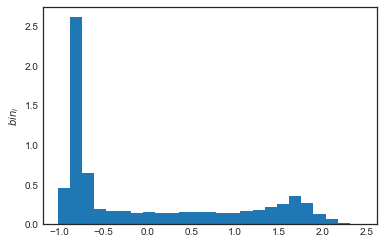

In [10]:
#view the distribution of values
plt.hist(X.flat, bins=25, normed=True)
plt.ylabel("$p(bin_i)$");
plt.ylabel("$bin_i$");

*check for understanding* (optional): we originally had 17 unique values of X but our histogram seems to indicate many more unique values after pre-processing. Why is that?

In [11]:
def plot_images(x, **kwargs):
    n_pix = int(np.sqrt(np.prod(X.shape[1:]))) #assumes images are square
    im_indices = np.random.choice(len(x), 20)
    fig, axes = subplots(nrows=4,ncols=5, figsize=(5,5), sharex=True, sharey=True, frameon=False)
    for i,ax in enumerate(axes.flat):
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        curr_i = im_indices[i]
        ax.imshow(x[curr_i].reshape(n_pix,n_pix), aspect="equal", **kwargs)
        ax.axis('off')

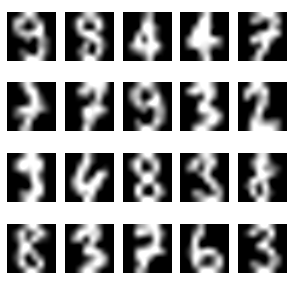

In [12]:
plot_images(X, cmap="gray", interpolation="spline16")

## Modeling

Here, we build models to predict our target variable. Below are two examples that use the pipeline function of sci-kit learn to unify the interface to both pre-processing and modeling steps. This method of setting up the problem will be important in the next section

In [13]:
from sklearn import linear_model

# first, we try a very simple model, logistic regression
lr_pipe = pipeline.Pipeline([
    ("scale", preprocessing.RobustScaler()),
    ("lr", linear_model.LogisticRegression())
])

model_selection.cross_val_score(lr_pipe, X, y, cv=5).mean()

0.91546464685017936

In [14]:
from sklearn import svm

# SVMs use the kernel trick to efficiently model complex relationships 
clf_pipe = pipeline.Pipeline([
    ("scale", preprocessing.RobustScaler()),
    ("clf", svm.SVC()),
])

model_selection.cross_val_score(clf_pipe, X, y, groups=y, cv=5).mean()

0.89990448830281833

# **Exercise 2:** 

Now, build your own model. You may use one of the above or any from the sci-kit learn package. Experiment with the parameters of the model as well as different pre-processing steps and see if you can improve the cross-validated accuracy.

## Grid search CV

Hyperparameters are an incredibly important aspect of building models. Often, the right hyperparameters can be the difference between a default model that does not perform well at all and one that excels in production. Finding the right hyperparameters is quite difficult and involves testing a model several times. This is a major benefit of using optimized libraries: we can test more models in less time, allowing us to better tune hyperparameters.

We can approach this problem in a principled way by searching over the space of parameters. We use the cross-validated score of the model to judge the performance of different hyperparameters.

Below is a case study. We have a pipeline that uses PCA as a pre-processing step. This is a common pre-processing step but, because PCA also serves to effectively regularize most models, it means that we now have two methods of regularization. Grid Search provides a principled way to weigh these regularization techniques against each other and find an optimal balance. Finally, whitening can also be incorporated into the PCA step to reduce colinearity in the features. This can either be helpful or harmful to performance depending on the model.

In [16]:
from sklearn import decomposition, pipeline

clf_pipe = pipeline.Pipeline([
    ("pca", decomposition.PCA()), 
    ("clf", linear_model.LogisticRegression(penalty="l1")),

])

clf_grid = model_selection.GridSearchCV(
    clf_pipe, {
        "pca__n_components": np.linspace(20,60, num=8, dtype="int"),
        "pca__whiten": [True, False],
        "clf__C": np.logspace(-3,1, num=8, base=2),
    },
    cv=5, verbose=1, n_jobs=-1)
# change verbose to reduce or increase the logging of gridsearch
# change n_jobs to modify the number of cores used. 

clf_grid.fit(X, y, groups=y, )

print("best cross validated accuracy: {}".format(clf_grid.best_score_))
print("best parameters: {}".format(clf_grid.best_params_))

Fitting 5 folds for each of 128 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   34.8s
[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed:  1.1min finished


best cross validated accuracy: 0.9282136894824707
best parameters: {'clf__C': 2.0, 'pca__n_components': 25, 'pca__whiten': False}


In [17]:
gridcv_results = pd.DataFrame(clf_grid.cv_results_)
gridcv_results["time"] = gridcv_results["mean_score_time"] + gridcv_results["mean_fit_time"]

In [18]:
gridcv_results.groupby(["param_pca__n_components"])["mean_test_score", "time"].mean()

,mean_test_score,time
param_pca__n_components,,
20,0.911484,0.254199
25,0.922197,0.298331
31,0.920388,0.338193
37,0.921536,0.452863
42,0.922336,0.484118
48,0.921918,0.559934
54,0.922301,0.405622
60,0.920597,0.460582


In [19]:
gridcv_results.groupby(["param_pca__whiten"])["mean_test_score", "time"].mean()

,mean_test_score,time
param_pca__whiten,,
False,0.919701,0.368834
True,0.920988,0.444627


In [20]:
gridcv_results.groupby(["param_clf__C"])["mean_test_score", "time"].mean()

,mean_test_score,time
param_clf__C,,
0.125000,0.914893,0.198449
0.185749,0.918962,0.205209
0.276022,0.920562,0.267580
0.410168,0.923310,0.326691
0.609507,0.922892,0.395719
0.905724,0.921884,0.431187
1.345900,0.920249,0.815408
2.000000,0.920006,0.613599


# **Exercise 3**: 

Write your own sklearn pipeline with more than one important hyperparameters and use GridSearchCV to optimize those hyperparameters. Use the above pattern as a starting point and feel free to experiment with other [sklearn models](http://scikit-learn.org/stable/user_guide.html). What is the optimal accuracy found by GridSearchCV? You should be able to find a model with a cross-validated accuracy of 95% or higher (possibly >97%). 

# Keras

Our last step is to leave the framework of sci-kit learn and use tensorflow, discussed in detail in the lecture. We will do this through Keras, which is a tool used to build tensorflow models more easily. 


We will use Keras (w optimized tensorflow backend) to build a classifier for the same digit data. We have evaluated previous models using 5-fold cross-validation so we'll use a for loop to do the same with our Keras model. First, look carefully at the example below that builds a feed-forward keras model with two hidden layers. 

In [26]:
import keras
import keras.backend as K

Tensorflow is the default backend used by keras.

In [33]:
K.backend()

'tensorflow'

With the tensorlfow backend, the variables, models, and operations in Keras are really just tensorflow objects.

In [32]:
K.ones((1,2,3))

<tf.Variable 'Variable_1:0' shape=(1, 2, 3) dtype=float32_ref>

So, with the following code, we can use Keras to very quickly set up and test a tensorflow model.

In [23]:
skf = model_selection.StratifiedKFold(n_splits=5)

acc_list = []
for train_index, test_index in skf.split(X, y):
    
    model = keras.Sequential([
        keras.layers.InputLayer(input_shape=X.shape[1:]),
        keras.layers.Dense(32, activation="elu"),
        keras.layers.Dense(32, activation="elu"),
        keras.layers.Dense(10, activation="softmax"),
    ])

    model.compile("nadam", "sparse_categorical_crossentropy", metrics=["acc"])
    
    model.fit(X[train_index],y[train_index],epochs=30,
    validation_split=0.25,
    verbose=0,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(
            factor=.5, patience=1, min_lr=1e-7, verbose=0),
        keras.callbacks.EarlyStopping(patience=4, verbose=0),
    ] )
    _, acc = model.evaluate(X[test_index],y[test_index])
    acc_list.append(acc)
    
print("mean cross-validated accuracy: {}".format(mean(acc_list)))

355/355 [==============================] - 0s 38us/step
mean cross-validated accuracy: 0.9231976990133154


# **Exercise 4**: 

Attempt to improve the two-layer Keras model by adding layers. 

Hints: 

Experiment with one or more of the following techniques. Refer to the previous Deep Learning lecture and the documentation for more information.

- Different layers
    - [Conv2D](https://keras.io/layers/convolutional/#conv2d) very good for images.
    - [MaxPool2D](https://keras.io/layers/pooling/#maxpooling2d) (also AvgPool2D) for stepping down the image size after one or more conv layers.
    - [BatchNormalization](https://keras.io/layers/normalization/#batchnormalization) great for improving learning performance in very deep networks. 
    - [GlobalAveragePooling2D](https://keras.io/layers/pooling/#globalaveragepooling2d) which are good for reducing the size of the output of blocks of convolutions.
    - [SeparableConv2D](https://keras.io/layers/convolutional/#separableconv2d) which reduce the number of parameters, great if your network is overfitting.
- Regularization techniques
    - [Dropout](https://keras.io/layers/core/#dropout)
    - [GaussianNoise](https://keras.io/layers/noise/#gaussiannoise)
    - [Regularizers](https://keras.io/regularizers/)

In the example, verbose output has been disabled for fitting. This is fine during testing but when tweaking the model it might be helpful to re-enable this output.

Additionally, the above layers might require changes to the shape of the input or intermediate layers. Consider using Reshape layers or Flatten layers to deal with these problems.